In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
mpl.rcParams['lines.linewidth'] = 2
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats
from statsmodels.compat import lzip
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore') 


## 데이터 불러오기 및 전처리

In [2]:
df=pd.read_csv('total_dataset.csv')
test=df[:100000]
test['PD_BUY_AM']=test['PD_BUY_AM'].apply(lambda x: x.replace(',',''))
test['PD_BUY_AM']=test['PD_BUY_AM'].apply(lambda x: x.replace('nan','0'))
test['PD_BUY_AM']=test['PD_BUY_AM'].astype('int')
test['Sales']=test['PD_BUY_AM']*test['PD_BUY_CT']
test['SESS_DT']=test['SESS_DT'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))
test['SESS_DT_period'] = test.SESS_DT.apply(lambda x: x[:7])
test=test.drop(['CLNT_ID_x','Unnamed: 0','SESS_ID','PD_ADD_NM','PD_NM','SESS_DT_period'],axis=1)

## 회귀분석
- 추가적으로 변수를 생성합니다.
1. 세션 접속 날짜를 기준으로, 일/주/분기 변수
2. 세션 접속 시간 전처리

In [3]:
test.SESS_DT=pd.DatetimeIndex(test.SESS_DT)
test['day']=pd.DatetimeIndex(test.SESS_DT).day
test['week']=pd.DatetimeIndex(test.SESS_DT).week
test['dayofweek']=pd.DatetimeIndex(test.SESS_DT).dayofweek
test['quarter']=pd.DatetimeIndex(test.SESS_DT).quarter
test['TOT_SESS_HR_V']=test['TOT_SESS_HR_V'].apply(lambda x: str(x))
test['TOT_SESS_HR_V']=test['TOT_SESS_HR_V'].apply(lambda x: x.replace(',',''))
test['TOT_SESS_HR_V']=test['TOT_SESS_HR_V'].apply(lambda x: x.replace('nan','0'))
test['TOT_SESS_HR_V']=test['TOT_SESS_HR_V'].astype('int')

- 고객들의 검색횟수, 세션 횟수, 세션 머문시간, 접속 지역, 구매 횟수, 성별, 나이, 접속일, 접속주, 접속한 분기등을 이용하여 구매량을 예측합니다.
- 범주형 변수의 경우 더미 변수로 변환합니다. - 성별, 지역 등

In [4]:
test1=test[['SEARCH_CNT','TOT_PAG_VIEW_CT', 'TOT_SESS_HR_V', 'DVC_CTG_NM', 
            'ZON_NM','PD_BUY_AM','CLNT_GENDER', 'CLNT_AGE', 'Sales', 'day', 
            'week', 'dayofweek', 'quarter']]
test1['Sales']=test1['Sales'].astype('int')
test1 = pd.get_dummies(test1)
test1.head()

,SEARCH_CNT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,PD_BUY_AM,CLNT_AGE,Sales,day,week,dayofweek,quarter,DVC_CTG_NM_desktop,DVC_CTG_NM_mobile,DVC_CTG_NM_tablet,ZON_NM_Busan,ZON_NM_Chungcheongbuk-do,ZON_NM_Chungcheongnam-do,ZON_NM_Daegu,ZON_NM_Daejeon,ZON_NM_Gangwon-do,ZON_NM_Gwangju,ZON_NM_Gyeonggi-do,ZON_NM_Gyeongsangbuk-do,ZON_NM_Gyeongsangnam-do,ZON_NM_Incheon,ZON_NM_Jeju-do,ZON_NM_Jeollabuk-do,ZON_NM_Jeollanam-do,ZON_NM_Seoul,ZON_NM_Ulsan,CLNT_GENDER_F,CLNT_GENDER_M
0,6.0,113.0,897,48000,40.0,48000,3,22,6,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,1.0,113.0,897,48000,40.0,48000,3,22,6,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,1.0,113.0,897,48000,40.0,48000,3,22,6,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,3.0,219.0,2268,43000,40.0,43000,23,30,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,3.0,219.0,2268,10000,40.0,20000,23,30,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [5]:
# 구매 금액을 y로, 나머지 변수들을 x로 설정하여 회귀분석을 실시합니다.
model = smf.ols("Sales ~ SEARCH_CNT + TOT_PAG_VIEW_CT + TOT_SESS_HR_V + CLNT_AGE + day + week + dayofweek + quarter+DVC_CTG_NM_desktop+DVC_CTG_NM_mobile+DVC_CTG_NM_tablet+CLNT_GENDER_F+CLNT_GENDER_M", data= test1).fit()
    
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     45.82
Date:                Wed, 07 Aug 2019   Prob (F-statistic):          9.57e-101
Time:                        13:08:24   Log-Likelihood:            -1.0178e+06
No. Observations:               79068   AIC:                         2.036e+06
Df Residuals:                   79056   BIC:                         2.036e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3.794e+04   1818.041     20.870      0.000    3.44e+04    4.15e+04
SEARCH_CNT           -46.2701    158.857     -0.291      0.771    -357.629     265.089
TOT_PAG_VIEW_CT       -0.5051      3.730     -0.135      0.892      -7.815       6.805
TOT_SESS_HR_V          0.1797      0.240      0.749      0.454      -0.290       0.650
CLNT_AGE             107.2896     43.602      2.461      0.014      21.830     192.749
day                 -321.6287     40.720     -7.899      0.000    -401.439    -241.819
week                1004.4163     91.775     10.944      0.000     824.538    1184.294
dayofweek           -182.2168    159.469     -1.143      0.253    -494.775     130.342
quarter            -1.148e+04   1423.991     -8.065      0.000   -1.43e+04   -8693.710
DVC_CTG_NM_desktop  4689.6415   2021.626      2.320      0.020     727.266    8652.017
DVC_CTG_NM_mobile   1115.2241   1805.725      0.618      0.537   -2423.986    4654.434
DVC_CTG_NM_tablet   3.214e+04   4472.987      7.185      0.000    2.34e+04    4.09e+04
CLNT_GENDER_F       9371.8357   1008.017      9.297      0.000    7396.129    1.13e+04
CLNT_GENDER_M       2.857e+04   1136.611     25.137      0.000    2.63e+04    3.08e+04
==============================================================================
Omnibus:                   135928.132   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        213488008.609
Skew:                          11.874   Prob(JB):                         0.00
Kurtosis:                     256.451   Cond. No.                     3.52e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.63e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

분석 결과, 회귀분석의 경우 가정이 까다운 모델이지만 통계적으로 구매에 영향을 미치는 변수를 찾기 위해 간단하게 진행하였습니다.
결과는 pvalue 기준 나이, 분기, 태블릿 사용자, 성별 등이 유의미하다고 나왔습니다.

Text(0.5, 1.0, 'Model1 Residuals Probability Plot')

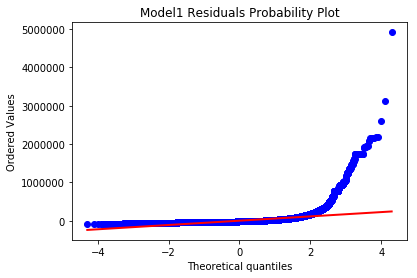

In [6]:
stats.probplot(model.resid, plot= plt)
plt.title("Model1 Residuals Probability Plot")

회귀 분석의 가정 중 하나인 잔차의 선형성을 파악하였습니다.

In [7]:
# 잔차의 정규성 또한 kstest로 판별 후 pvalue로 만족하였습니다.
stats.kstest(model.resid, 'norm')


KstestResult(statistic=0.7301562735085537, pvalue=0.0)